# VGGish
---

## Overview
- VGGモデル(Imgae Recognition)の亜種でAudio classification用に一部変更

> ### VGG
> - Oxford Univ.のVGG(Visual Geometry Group)という研究グループが開発したAlexNetの後続モデル
> - 原著論文:[Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).](https://arxiv.org/abs/1409.1556)
> - ConvNet configurations(A, A-LAN, B, C, D, Eの6種類)によって畳み込み層の数等が変化しそれによってVGG16(ネットワークの深さが16:Config D),VGG19(ネットワークの深さが19:Config E)などと呼ばれる
>     - 原著論文内のAblation実験ではDとEが性能と効率性のバランスが良く多く用いられている(特にD、つまりVGG16)
>
> - 2014年のILSVRC:優勝モデルであり、とてもシンプルなので実用的でよく用いられる
>     - ILSVRC2012年優勝モデルのAlexNetが8層CNNであったことから当時は圧倒的に大きな多層CNNモデルだった(論文名からも見て取れる)
> - ネットワーク構成は以下の表を参照
>     - conv3-64は3x3(xチャネル数)のフィルタを64種類という意味である
>     - FC4096は4096unitから成る全結合層(Fully connected layer)  
> - 構成表の下にVGG16の構成図と各層における層の種類と出力形式を示した
>>  #### Reference
>> - [Deep Learning - Mashykom WebSite](https://www.koi.mashykom.com/deep_learning.html)
>> - [Keras：VGG16、VGG19とかってなんだっけ？？](https://qiita.com/MuAuan/items/86a56637a1ebf455e180)
>> - [VGGネットワーク（VGGNet）とは？要点を爆速rikai入門！](https://aizine.ai/glossary-vgg/)
>> - [VGGNet: 初期の定番CNN(一番詳しく載ってる)](https://cvml-expertguide.net/terms/dl/cnn-backbone/vggnet/)
>> - [Deep Learning VGG](http://www.sanko-shoko.net/note.php?id=pyk1)
>> - [VGG16モデルを使用してオリジナル写真の画像認識を行ってみる](https://newtechnologylifestyle.net/vgg16originalpicture/)

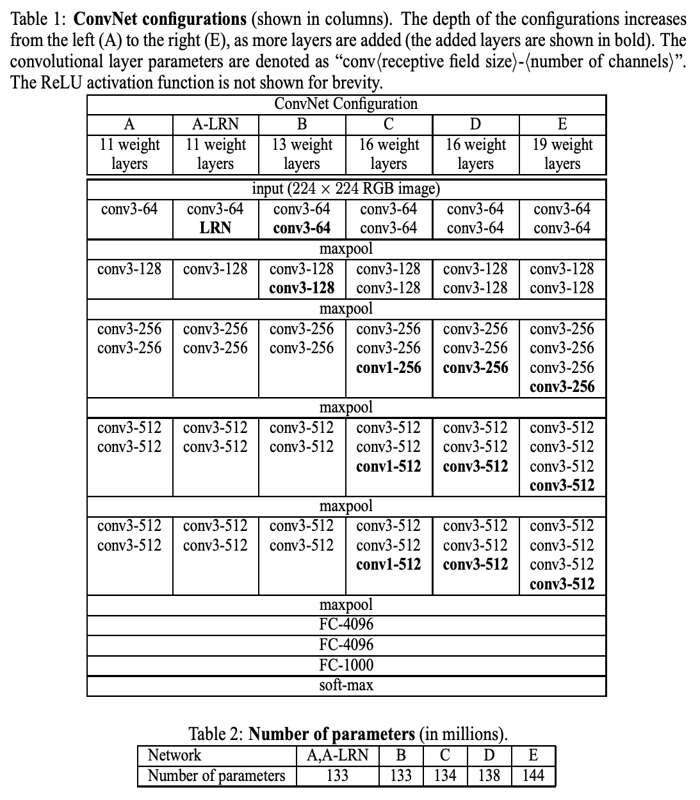

In [8]:
from PIL import Image
filename = "Materials/Image/slide.png"
#原著論文から引用
im = Image.open(filename)
im.resize((700, 800))

下2図:VGG16の構成図と各層の出力形式とパラメータ数

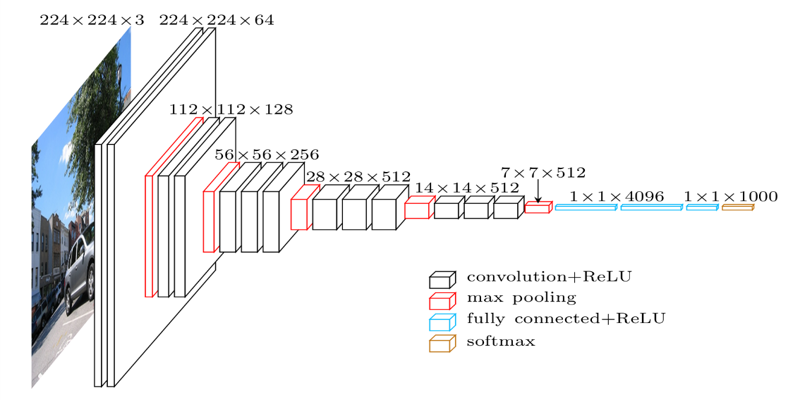

In [12]:
from PIL import Image
filename = "Materials/Image/slide1.png"
#原著論文から引用
im = Image.open(filename)
im.resize((800, 400))

- VGGからの変更点は以下に示した
    - 元のVGGのConvNet ConfigurationのAをベースに使用
    - 入力は音をlog mel spectrogramに変換した96x64の画像なので入力サイズを96x64に変更
    - 最後のConvolution層＋MaxPool層の二層(構成表の5段目)を削除して4段に
    - Predictionを行う最後のFC1000(出力形式:(1, 1000))をFC128(出力形式:(1, 128))に変更
    - 最後のFC128の後、softmaxには渡さず、その値のまま出力している
        - そのため後述のVGGishをwarm start modelとして使用する場合は、この出力をsoftmaxにしてから利用する必要がある

- 学習済みモデル
- 学習にはYoutube-8Mデータセットの予備版(preliminary version of the youTube-8M dataset)を使用
- [TensorFlow hub](https://tfhub.dev/google/vggish/1)で公開
- 公開元は[TensorFlow Model Garden](https://github.com/tensorflow/models/tree/master/research/audioset/vggish)にあるので詳細はここを確認

## 1. Input
 - 任意の長さのaudio waveformを含むTensor配列orNumpy配列
     - 値は[-1.0, 1.0]の範囲のfloat32
     - 単一(1次元、モノラル)
     - 16,000[Hz]でサンプリング
 - 内部的には受け取った配列を更に960[ms]の重複のないフレームに分割し、この分割した後のバッチをlog mel spectrogramにしてそれを入力とする

## 2. Output
 - (N, 128)の二次元配列(入力形式によってTensor配列orNumpy配列)
 - 値はfloat32
 - Nは入力されたデータを960[ms]で分割できた数
 - テンソルの各行は、その960[ms]フレームの意味内容に対応する128次元enbedding表現

## 3. Usage
  1. 特徴抽出器として用いる
      - VGGishは音の特徴を上手くenbeddingすることができるように学習されている
      - VGGishの出力の128次元embeddingを別のモデルの入力特徴として使用すれば、多くのラベル付きデータを用いることなく特定のタスクのためのモデルを学習させることが可能
  2. より大きなモデルの一部として用いる
      - VGGishの上に層をさらに追加していき新たなモデルを作成する
      - VGGishはそのモデルのためのwarm startとして扱う
      - そのように層を追加し、モデル全体を学習する方法もTensorFlow Model Gardenに公開されている

## 4. Limitations
 - VGGishはYoutubeの800万の動画で学習しており、それらには多様な動画が含まれているが、平均的なYoutube動画と任意のタスクに期待される入力との間にはドメインのミスマッチがある可能性がある
 - そのためある程度の微調整とfine-tuningを行う必要がある